# Optimizing Retail Sales: RFM Model with K-Means Clustering

## Data Cleaning: Preparing the Dataset for Analysis

#### Imports

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import numpy as np
from sklearn.decomposition import PCA

Fontconfig warning: ignoring UTF-8: not a valid region tag
Matplotlib is building the font cache; this may take a moment.


In [2]:
# Loading CSV File
file_path = 'online_retail_listing.csv'
raw_data = pd.read_csv(file_path, delimiter=';', encoding='latin1', decimal=',')

In [3]:
raw_data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,1.12.2009 07:45,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,1.12.2009 07:45,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,1.12.2009 07:45,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,1.12.2009 07:45,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,1.12.2009 07:45,1.25,13085.0,United Kingdom


In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1048575 non-null  object 
 1   StockCode    1048575 non-null  object 
 2   Description  1044203 non-null  object 
 3   Quantity     1048575 non-null  int64  
 4   InvoiceDate  1048575 non-null  object 
 5   Price        1048575 non-null  float64
 6   Customer ID  811893 non-null   float64
 7   Country      1048575 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 64.0+ MB


In [5]:
raw_data.nunique()

Invoice        52961
StockCode       5304
Description     5697
Quantity        1048
InvoiceDate    47046
Price           2784
Customer ID     5924
Country           43
dtype: int64

In [6]:
# Check for null values in the dataset
_raw_data = raw_data.copy()
_raw_data.isnull().sum()

Invoice             0
StockCode           0
Description      4372
Quantity            0
InvoiceDate         0
Price               0
Customer ID    236682
Country             0
dtype: int64

In [11]:
# Drop rows with missing Customer ID (necessary for RFM analysis)
clean_data = _raw_data.dropna(subset=['Customer ID'])

In [12]:
# Checking for null value cleanup
clean_data.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [13]:
# Create a full copy of the dataset to avoid chained assignment issues
clean_data = clean_data.copy()

# Convert Customer ID to string
clean_data['Customer ID'] = clean_data['Customer ID'].astype(float).astype(int)
clean_data['Customer ID'] = clean_data['Customer ID'].astype(str)

In [14]:
# Filter data with negative numbers
clean_data = clean_data[(clean_data['Quantity'] > 0) & (clean_data['Price'] > 0)]
clean_data['Price'] = clean_data['Price'].astype(float)

# Convert InvoiceDate in Datetime from object type. 
clean_data["InvoiceDate"] = pd.to_datetime(
    clean_data["InvoiceDate"], 
    format="%d.%m.%Y %H:%M",  # Specify the expected format
    dayfirst=True,            # Ensure day is parsed first
    errors='coerce'           # Handle invalid dates by setting them to NaT
)

# Verifying that data has been cleaned

print(clean_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 793309 entries, 0 to 1048574
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      793309 non-null  object        
 1   StockCode    793309 non-null  object        
 2   Description  793309 non-null  object        
 3   Quantity     793309 non-null  int64         
 4   InvoiceDate  793309 non-null  datetime64[ns]
 5   Price        793309 non-null  float64       
 6   Customer ID  793309 non-null  object        
 7   Country      793309 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 54.5+ MB
None


In [15]:
clean_data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom


## Creating RFM Metrics (Recency, Frequency, Monetary) 

In [16]:
# Define a reference date (e.g., max date in the dataset)
reference_date = clean_data['InvoiceDate'].max()

#### We group the data by clients

In [17]:
# Aggregate data to calculate RFM metrics
rfm_data = clean_data.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'Invoice': 'nunique',  # Frequency
    'Price': lambda x: (x * clean_data.loc[x.index, 'Quantity']).sum()  # Monetary
})

# Rename columns for clarity
rfm_data.rename(columns={
    'InvoiceDate': 'Recency',
    'Invoice': 'Frequency',
    'Price': 'Monetary'
}, inplace=True)

In [18]:
rfm_data.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346,320,12,77556.46
12347,34,7,5408.50
12348,70,5,2019.40
12349,13,4,4428.69
12350,304,1,334.40


In [19]:
rfm_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5860 entries, 12346 to 18287
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Recency    5860 non-null   int64  
 1   Frequency  5860 non-null   int64  
 2   Monetary   5860 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 183.1+ KB


## Preparing RFM Data for K-Means Clustering

In [20]:
# Initialize the scaler
scaler = StandardScaler()

# Apply the scaler to the RFM metrics
rfm_scaled = scaler.fit_transform(rfm_data)

# Convert back to a DataFrame for easier handling
rfm_scaled = pd.DataFrame(rfm_scaled, columns=rfm_data.columns, index=rfm_data.index)

In [21]:
rfm_scaled.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346,0.578473,0.449494,5.198186
12347,-0.800021,0.060569,0.170859
12348,-0.626504,-0.095001,-0.065296
12349,-0.901239,-0.172786,0.102585
12350,0.501354,-0.406142,-0.182708


In [22]:
rfm_scaled.describe()

,Recency,Frequency,Monetary
count,5.860000e+03,5.860000e+03,5.860000e+03
mean,2.788820e-17,2.546314e-17,6.062651e-18
std,1.000085e+00,1.000085e+00,1.000085e+00
min,-9.638978e-01,-4.061417e-01,-2.058073e-01
25%,-8.434001e-01,-4.061417e-01,-1.820049e-01
50%,-4.819069e-01,-2.505715e-01,-1.444398e-01
75%,8.435678e-01,6.056883e-02,-4.681333e-02
max,2.569095e+00,2.993004e+01,4.141684e+01


## Determining the Optimal Number of Clusters

#### Elbow Method

In [23]:
# Initialize variables
inertia = []
k_range = range(1, 11)  # Test clusters from 1 to 10

In [24]:
for k in k_range:
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1024)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

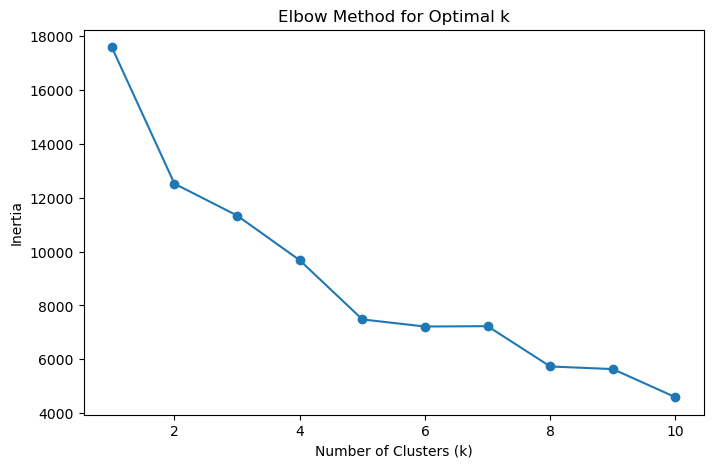

In [25]:
# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

#### Silhouette Score

In [27]:
# Initialize variables
silhouette_scores = []

In [28]:
# Loop over different values of k (from 2 to 10)
for k in range(2, 11):  # Silhouette score requires at least 2 clusters
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    score = silhouette_score(rfm_scaled, kmeans.labels_)
    silhouette_scores.append(score)

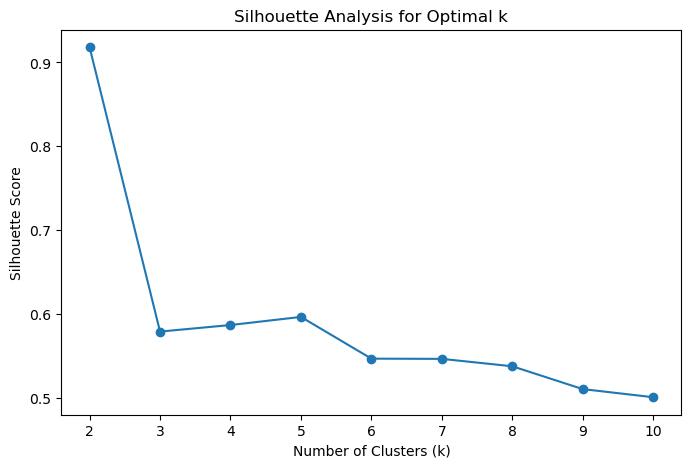

In [29]:
# Plot the Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal k')
plt.show()

The number of clusters was determined using both the Elbow Method and the Silhouette Score. While the Elbow Method indicated a potential optimal point at k=4, the Silhouette Score demonstrated better cluster quality at k=5. This balance between interpretability and segmentation detail makes k=5 the most suitable choice for this analysis.

## Applying K-Means Clustering: Segmenting Customers

In [54]:
# Train the K-Means model with k=5
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
kmeans.fit(rfm_scaled)

KMeans(n_clusters=5, n_init=10, random_state=42)

In [55]:
# Assign the clusters to each customer
rfm_data['Cluster'] = kmeans.labels_

In [56]:
# View the first rows of the clustered data
print(rfm_data.head())

             Recency  Frequency  Monetary  Cluster
Customer ID                                       
12346            320         12  77556.46        4
12347             34          7   5408.50        1
12348             70          5   2019.40        1
12349             13          4   4428.69        1
12350            304          1    334.40        0


In [57]:
# Check the distribution of customers across clusters
print(rfm_data['Cluster'].value_counts())

Cluster
1    3530
0    1914
4     389
3      23
2       4
Name: count, dtype: int64


In [58]:
cluster_summary = rfm_data.groupby('Cluster').mean()
print(cluster_summary)

            Recency   Frequency       Monetary
Cluster                                       
0        466.751829    2.176594     755.753178
1         75.454391    5.035411    1859.599006
2          5.750000  209.250000  429456.910000
3         22.347826  123.652174   96557.848348
4         29.933162   27.853470   13818.452090


In [69]:
# Extract centroids from the trained KMeans model
centroids = kmeans.cluster_centers_

In [70]:
# Convert centroids back to the original scale for interpretability (optional)
centroids_original = centroids * rfm_scaled.std(axis=0).values + rfm_scaled.mean(axis=0).values

In [74]:
# Convert centroids to a DataFrame with the same column names
centroids_df = pd.DataFrame(centroids, columns=rfm_scaled.columns)

In [75]:
# Apply PCA to the centroids
centroids_2d = pca.transform(centroids_df)

#### Charts

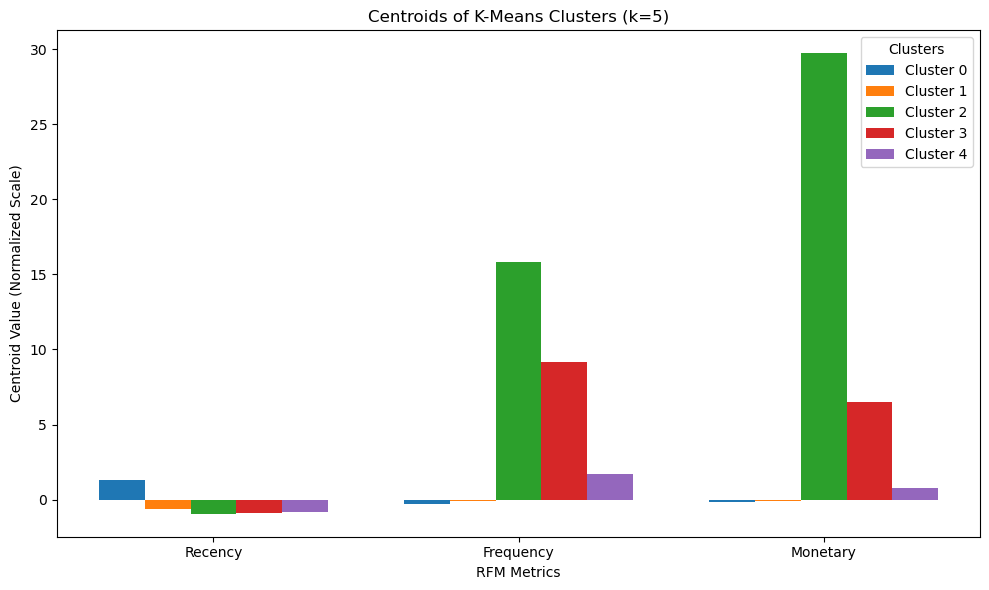

In [76]:
# Create a bar chart for the centroids
fig, ax = plt.subplots(figsize=(10, 6))
index = np.arange(len(rfm_data.columns[:-1]))  # Exclude the 'Cluster' column
bar_width = 0.15

for i in range(len(centroids)):
    ax.bar(
        index + i * bar_width, 
        centroids[i], 
        bar_width, 
        label=f'Cluster {i}'
    )

# Add labels and title
ax.set_xlabel('RFM Metrics')
ax.set_ylabel('Centroid Value (Normalized Scale)')
ax.set_title('Centroids of K-Means Clusters (k=5)')
ax.set_xticks(index + bar_width * (len(centroids) - 1) / 2)
ax.set_xticklabels(['Recency', 'Frequency', 'Monetary'])
ax.legend(title="Clusters")

# Display the chart
plt.tight_layout()
plt.show()

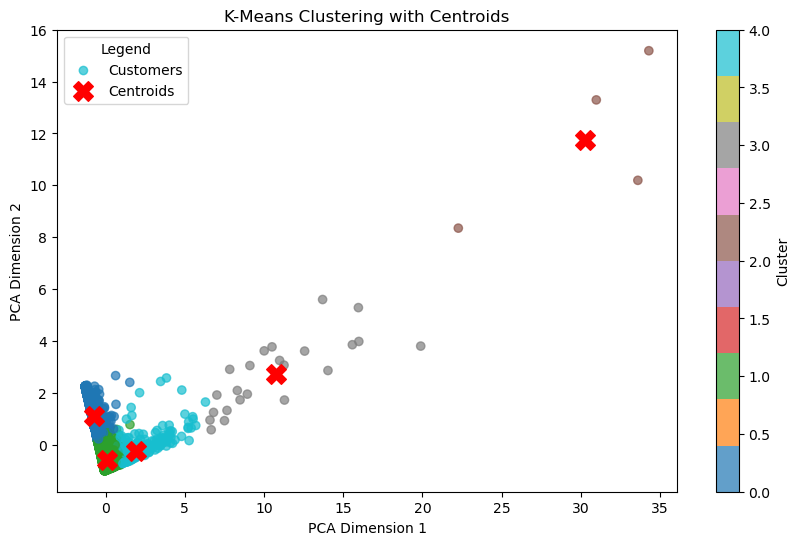

In [77]:
# Plot the clusters
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(
    rfm_2d[:, 0], rfm_2d[:, 1], 
    c=rfm_data['Cluster'], cmap='tab10', alpha=0.7, label='Customers'
)

# Plot the centroids
ax.scatter(
    centroids_2d[:, 0], centroids_2d[:, 1], 
    c='red', marker='X', s=200, label='Centroids'
)

# Add labels and legend
ax.set_title('K-Means Clustering with Centroids')
ax.set_xlabel('PCA Dimension 1')
ax.set_ylabel('PCA Dimension 2')
ax.legend(title='Legend')
plt.colorbar(scatter, label='Cluster')
plt.show()

In [78]:
rfm_data['Recency'].describe()

count    5860.000000
mean      199.982594
std       207.490532
min         0.000000
25%        25.000000
50%       100.000000
75%       375.000000
max       733.000000
Name: Recency, dtype: float64

## Analyzing Clusters: Generating Insights

In [81]:
# Cluster summary
cluster_summary = rfm_data.groupby('Cluster').mean()
print(cluster_summary)

            Recency   Frequency       Monetary
Cluster                                       
0        466.751829    2.176594     755.753178
1         75.454391    5.035411    1859.599006
2          5.750000  209.250000  429456.910000
3         22.347826  123.652174   96557.848348
4         29.933162   27.853470   13818.452090


<Figure size 1000x600 with 0 Axes>

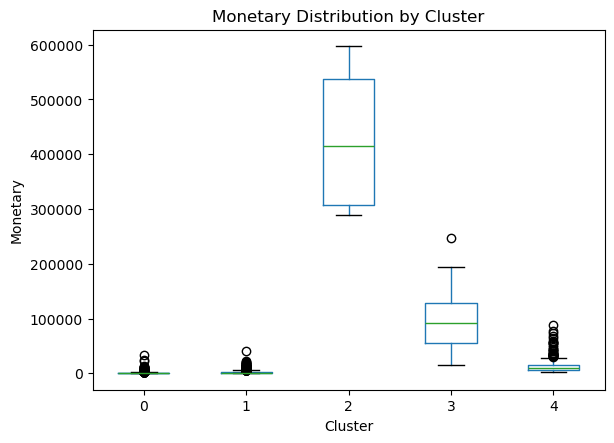

In [82]:
# Boxplot for Monetary by Cluster
plt.figure(figsize=(10, 6))
rfm_data.boxplot(column='Monetary', by='Cluster', grid=False)
plt.title('Monetary Distribution by Cluster')
plt.suptitle('')  # Remove default title
plt.xlabel('Cluster')
plt.ylabel('Monetary')
plt.show()

Cluster 0: **Dormant Customers**

* Recency: Very high (466 days), meaning they have not purchased recently.
* Frequency: Low, with an average of 2 purchases.
* Monetary: Low spending (755.75).
* Customers: This is the second-largest group with 1914 customers.

Cluster 1: **Average Customers**

* Recency: Moderate (75 days).
* Frequency: Moderate (5 purchases).
* Monetary: Medium spending (1859.60).
* Customers: The largest group with 3530 customers.

Cluster 2: **VIP Customers**

* Recency: Very recent (5.75 days).
* Frequency: Extremely high (209 purchases).
* Monetary: Exceptionally high spending (429,456.91).
* Customers: Very few (4 customers).

Cluster 3: **Loyal Customers**

* Recency: Very recent (22.35 days).
* Frequency: High (123 purchases).
* Monetary: Significant spending (96,557.85).
* Customers: A small group (23 customers).

Cluster 4: **High-Value Customers**

* Recency: Recent (29.93 days).
* Frequency: High (27 purchases).
* Monetary: High spending (13,818.45).
* Customers: 389 customers.

**General Insights**

* Most Important Clusters:
Cluster 2 (VIP) and Cluster 3 (Loyal) are the most valuable due to their high frequency and spending. They represent a small but critical proportion of the total.

* Less Active Clusters:
Cluster 0 (Dormant) has the greatest potential for reactivation, given the large number of inactive customers.


* Segmentation Strategies:
Design specific campaigns for each cluster based on their key characteristics.

## Business Recommendations: Actionable Insights for the Retailer

**Dormant Customers (Cluster 0)**

* Insight: These customers haven't purchased in a long time (466 days on average) and have low engagement (frequency of 2).
* Actionable Steps:
    * Reactivation Campaigns:
        * Offer targeted discounts or limited-time offers to encourage them to make a purchase.
        * Send personalized emails or SMS with messages like "We miss you! Enjoy 20% off on your next order."
* Win-Back Strategies:
    * Highlight new products or services they haven’t seen yet.
    * Use feedback forms to understand why they stopped purchasing.

**Average Customers (Cluster 1)** 

* Insight: This is the largest segment (3530 customers). They purchase moderately and are relatively active.
* Actionable Steps:
    * Retention Campaigns:
        * Provide loyalty points or rewards for consistent purchases.
        * Create a subscription program to encourage regular spending.
    * Personalized Recommendations:
        * Use their past purchase history to suggest complementary or frequently bought items.
        * Offer tiered discounts based on spending thresholds (e.g., “Spend $50 to get $10 off”).

**VIP Customers (Cluster 2)**
* Insight: These 4 customers are the most valuable. They buy frequently (209 purchases) and spend extraordinarily high amounts.
* Actionable Steps:
    * Exclusive Benefits:
        * Assign dedicated account managers or customer success representatives.
        * Provide early access to new products, exclusive sales, or VIP-only events.
    * Recognition:
        * Celebrate their loyalty with personalized thank-you messages or gifts.
        * Mention them in newsletters or events (with their consent) to strengthen brand connection.

**Loyal Customers (Cluster 3)**
* Insight: With 23 customers, they are frequent buyers (123 purchases) with significant spending. They exhibit high brand loyalty.
* Actionable Steps:
    * Enhance Loyalty:
        * Offer multi-tiered loyalty programs with additional perks for frequent buyers.
        * Provide free shipping, exclusive offers, or bonus loyalty points for referrals.
    * Upsell and Cross-Sell:
        * Introduce premium product bundles or services they might enjoy based on their preferences.
        * Incentivize them to increase spending by highlighting value bundles.

**High-Value Customers (Cluster 4)**
* Insight: These 389 customers are active, with a reasonable purchase frequency and relatively high spending.
* Actionable Steps:
    * Engagement Campaigns:
        * Encourage them to become even more engaged by introducing milestone rewards for frequent purchases.
        * Send personalized reminders about seasonal sales or new arrivals.
    * Feedback Loop:
        * Collect feedback to understand how to elevate their experience further.
        * Use their insights to improve services or expand product offerings.

## General Recommendations
1. **Customer Segmentation Marketing:**
    * Create tailored marketing campaigns targeting each segment's specific needs and behaviors.
    * Use email automation tools to personalize communication for each cluster.
2. **Focus on Retention:**
    * Invest in retaining clusters with high spending (Clusters 2, 3, and 4).
    * Implement post-purchase follow-ups and surveys to understand customer satisfaction.
3. **Data-Driven Decisions:**
    * Continuously monitor the performance of each segment and adapt strategies based on results.
    * Use predictive analytics to identify customers likely to churn and act proactively.
4. **Invest in Customer Relationships:**
    * Strengthen customer relationships across all clusters by fostering trust and delivering excellent service.
    * Regularly review and refine loyalty and rewards programs to ensure they remain attractive.
# 

## Complementary Analysis.

### TOP 20 CUSTOMERS

In [97]:
# Step 1: Identify the Top 20 customers based on Monetary value
top_20_customers = rfm_data[['Monetary']].sort_values(by='Monetary', ascending=False).head(20)

In [98]:
# Step 2: Add customer identifiers for visualization
top_20_customers['Customer ID'] = top_20_customers.index.astype(str)

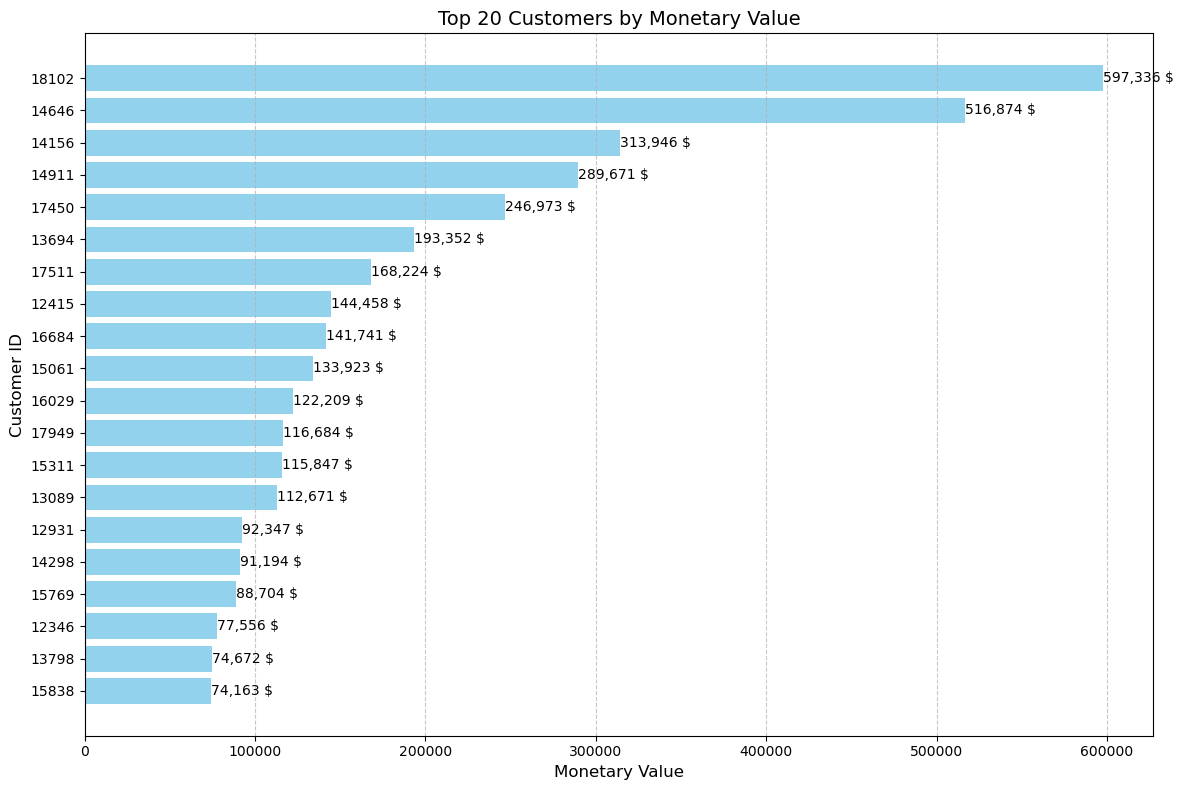

In [134]:
# Step 3: Plot a horizontal bar chart with data labels
plt.figure(figsize=(12, 8))

bars = plt.barh(
    top_20_customers['Customer ID'], 
    top_20_customers['Monetary'], 
    color='skyblue', 
    alpha=0.9
)

# Add data labels to the bars
for bar in bars:
    plt.text(
        bar.get_width(), 
        bar.get_y() + bar.get_height() / 2, 
        f'{bar.get_width():,.0f} $',  # Format with commas for thousands and append $
        va='center', 
        fontsize=10
    )

# Add title and labels
plt.title('Top 20 Customers by Monetary Value', fontsize=14)
plt.xlabel('Monetary Value', fontsize=12)
plt.ylabel('Customer ID', fontsize=12)

# Invert the y-axis for better readability
plt.gca().invert_yaxis()

# Add grid for readability
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [110]:
porcentual_monetary_top_20 = round(((top_20_customers['Monetary'].sum() / rfm_data['Monetary'].sum())*100),2)

In [112]:
print ( f'The TOP 20 consumers represent {porcentual_monetary_top_20}% of the total monetary')

The TOP 20 consumers represent 21.43% of the total monetary


### Pareto Analysis: Identifying Key Customers Driving Revenue

In [101]:
# Step 1: Calculate total monetary value
total_monetary = rfm_data['Monetary'].sum()

In [114]:
# Step 2: Calculate cumulative monetary contribution for each customer
rfm_data_sorted = rfm_data[['Monetary']].sort_values(by='Monetary', ascending=False)
rfm_data_sorted['Cumulative Monetary'] = rfm_data_sorted['Monetary'].cumsum()

In [115]:
# Step 3: Calculate cumulative percentage contribution
rfm_data_sorted['Cumulative Percentage'] = (rfm_data_sorted['Cumulative Monetary'] / total_monetary) * 100

In [116]:
# Step 4: Identify the threshold for top 20% customers
pareto_threshold = len(rfm_data_sorted) * 0.2
top_20_percent_customers = rfm_data_sorted.iloc[:int(pareto_threshold)]

In [117]:
# Results
top_20_customers_count = len(top_20_percent_customers)
revenue_80_percent = rfm_data_sorted[rfm_data_sorted['Cumulative Percentage'] <= 80]['Monetary'].sum()

In [120]:
# Print results with formatting
print(f"Total Monetary Value: {total_monetary:,.2f}$".replace(',', 'X').replace('.', ',').replace('X', '.'))
print(f"Number of customers contributing to 80% of revenue: {len(top_20_percent_customers)}")
print(f"Top 20% of customers contribute {top_20_percent_customers['Monetary'].sum():,.2f}$".replace(',', 'X').replace('.', ',').replace('X', '.') + " to the total revenue.")
print(f"Remaining 80% of customers contribute {total_monetary - top_20_percent_customers['Monetary'].sum():,.2f}$".replace(',', 'X').replace('.', ',').replace('X', '.') + " to the total revenue.")

Total Monetary Value: 17.324.932,09$
Number of customers contributing to 80% of revenue: 1172
Top 20% of customers contribute 13.343.335,00$ to the total revenue.
Remaining 80% of customers contribute 3.981.597,09$ to the total revenue.


### K-means and Pareto Analysis

In [124]:
# Step 1: Merge RFM data with clusters
pareto_with_clusters = rfm_data_sorted.merge(
    rfm_data[['Cluster']], 
    left_index=True, 
    right_index=True
)

In [125]:
# Step 2: Identify top 20% customers
top_20_with_clusters = pareto_with_clusters.iloc[:int(pareto_threshold)]

In [126]:
# Step 3: Group by clusters to analyze their contribution
cluster_contribution = top_20_with_clusters.groupby('Cluster')['Monetary'].sum()
cluster_contribution_percentage = (cluster_contribution / top_20_with_clusters['Monetary'].sum()) * 100

In [127]:
# Step 4: Count the number of customers per cluster in the top 20%
cluster_customer_count = top_20_with_clusters['Cluster'].value_counts()

In [129]:
# Display results
print("Monetary Contribution by Cluster in Top 20% Customers:")
print(cluster_contribution.apply(lambda x: f"{x:,.2f}$".replace(',', 'X').replace('.', ',').replace('X', '.')))
print("\nPercentage Contribution by Cluster:")
print(cluster_contribution_percentage.apply(lambda x: f"{x:,.2f}%".replace('.', ',')))

print("\nNumber of Customers in Top 20% by Cluster:")
print(cluster_customer_count)

Monetary Contribution by Cluster in Top 20% Customers:
Cluster
0      405.589,76$
1    3.636.067,38$
2    1.717.827,64$
3    2.220.830,51$
4    5.363.019,71$
Name: Monetary, dtype: object

Percentage Contribution by Cluster:
Cluster
0     3,04%
1    27,25%
2    12,87%
3    16,64%
4    40,19%
Name: Monetary, dtype: object

Number of Customers in Top 20% by Cluster:
Cluster
1    696
4    384
0     65
3     23
2      4
Name: count, dtype: int64


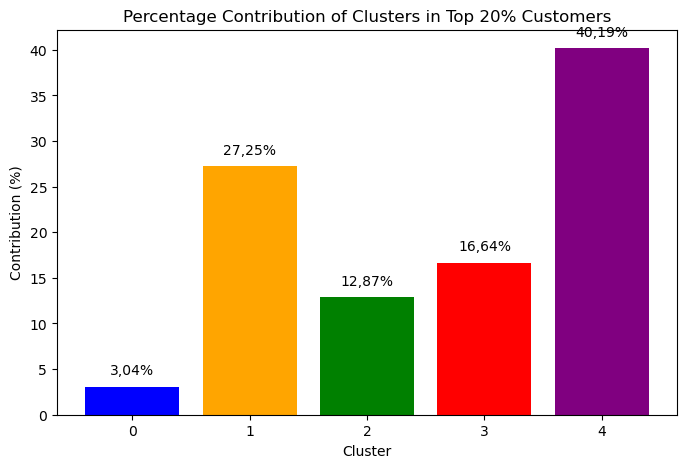

In [132]:
# Bar plot for monetary contribution by cluster
plt.figure(figsize=(8, 5))
bars = plt.bar(
    cluster_contribution_percentage.index, 
    cluster_contribution_percentage, 
    color=['blue', 'orange', 'green', 'red', 'purple']
)
plt.title('Percentage Contribution of Clusters in Top 20% Customers')
plt.xlabel('Cluster')
plt.ylabel('Contribution (%)')
plt.xticks(rotation=0)

# Adding data labels
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        yval + 1, 
        f'{yval:,.2f}%'.replace('.', ','), 
        ha='center', 
        va='bottom'
    )
plt.show()

## Final Insights and Recommendations:

**Clusters 3 and 4: Premium Customers**
* Key Data:
    * Only 27 customers (23 in Cluster 3, 4 in Cluster 4) generate over €7.5 million in revenue.
    * High frequency and monetary value.
* Recommendations:
  1. Exclusive Loyalty Programs: VIP discounts, free shipping, access to premium products or events.
  2. Personalized Service: Dedicated support channels or account managers.
  3. Co-Creation: Engage them in surveys or new product panels.
  4. Luxury Offers: Limited editions or premium product lines tailored for them.

**Clusters 0 and 1: Strategic Customers**
* Key Data:
    * Account for nearly 90% of customers in the Top 20%.
    * Generate moderate revenue but ensure stability through volume.
* Recommendations:
    1. Targeted Promotions: Discounts, combo deals, and bulk-buy incentives.
    2. Loyalty Points System: Reward frequent purchases with redeemable points.
    3. Educational Marketing: Product tutorials and recommendations.
    4. Cross-Selling: Suggest complementary or premium products.

**Cluster 2: High-Value Niche Customers**
* Key Data:
    * Just 4 customers but exceptionally high revenue contribution.
* Recommendations:
    1. Executive Engagement: Foster direct relationships with top management.
    2. Exclusive Offers: Personalized deals and added-value services.
    3. Behavior Analysis: Study their preferences to attract similar profiles.

#### Summary:
Focus on **Clusters 3 and 4** for premium loyalty strategies and high-value retention. Leverage **Clusters 0 and 1** for consistent volume and upselling opportunities. Use insights from **Cluster 2** to replicate success and attract similar high-value customers.